# Pós-graduação em Ciência da Computação - UFABC
## Projeto de Mineração de Dados - Professor Thiago Covões
### Alunos: Fernanda Borges e Thiago Rizuti

# Introdução

O objetivo do projeto é interpretar automaticamente captchas de áudio, que neste caso são áudios com quatro caracteres gravados pelos alunos separadamente e concatenados de forma aleatória em arquivos .wav.

Esta base foi crida considerando-se os seguintes caracteres: a,b,c,d,h,m,n,x,6,7. Ela contém 200 observações para o conjunto de treinamento e 147 observações para o conjunto de validação.

Primeiramente desenvolvemos classificadores capazes de distinguir cada caractere separadamente, sendo que cada caractere do captcha representa uma classe. Em seguida consideramos que para cada arquivo .wav recebido a predição é a combinação das predições individuais para cada caractere.

Para realizar este projeto foram usadas as bibliotecas:
- librosa, que é um pacote para análise de áudios e músicas; 
- pandas, que é uma ferramenta para estruturação e análise de dados;
- numpy, que é muito utilizada para computações científicas;
- matplotlib, que é utilizada principalmente para a plotagem de imagens em 2D;
- sklearn, que possui ferramentas para mineração de dados;

In [1]:
import os
import librosa 
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
%matplotlib inline

Também implementamos as seguintes funções, que serão explicadas ao longo do relatório.

In [2]:
%load_ext autoreload
%autoreload 2
%aimport codigo
from codigo import read_audio, extract_features, select_model, train_model, evaluate_model 

# Análise Exploratória

O primeiro desafio foi segmentar cada captcha separando o áudio referente a cada caractere. Para isso utilizamos a função load da biblioteca librosa que retorna a série temporal do áudio e a taxa de amostragem dela. Observamos as séries temporais de alguns captchas e identificamos que eles condiziam com o processo de gravação dos áudios, pois havia uma separação visual a cada dois segundos entre as oscilações mais representativas.

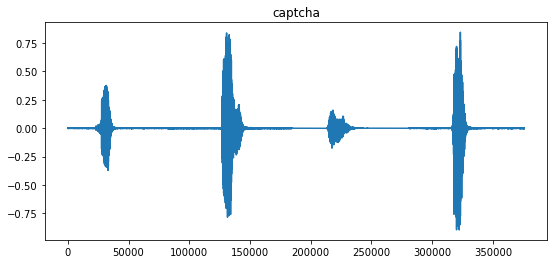

In [3]:
signal, sampling_rate = librosa.load('base_treinamento_I/bnma.wav', None)

plt.figure(figsize=(9, 4))
plt.title('captcha')
plt.plot(signal)

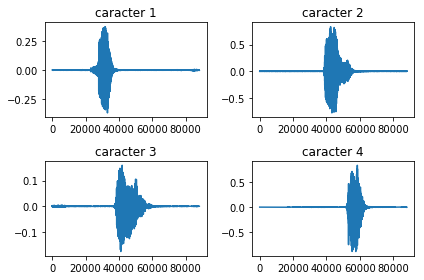

In [4]:
chars = [] 
chars += [signal[sampling_rate*2*i:sampling_rate*2*(i+1)] for i in range(4)]

fig = plt.figure()

plt.subplot(2, 2, 1)
plt.title('caracter 1')
plt.plot(chars[0])

plt.subplot(2, 2, 2)
plt.title('caracter 2')
plt.plot(chars[1])

plt.subplot(2, 2, 3)
plt.title('caracter 3')
plt.plot(chars[2])

plt.subplot(2, 2, 4)
plt.title('caracter 4')
plt.plot(chars[3])
plt.tight_layout()
plt.show()

Decidimos então quebrar a série temporal de cada captcha em 4 intervalo de 2 segundos.

Usamos a função read_audio para ler e dividir em caracteres as bases de treinamento e validação. Definimos como base de treinamento a união das bases da primeira etapa com a base de treinamento da segunda etapa. Para validação, usamos a base de validação da segunda etapa.

In [5]:
train_audios = read_audio('base_treinamento_I') + read_audio('base_treinamento_II') + read_audio('base_validacao_I')
valid_audios = read_audio('base_validacao_II')
print('base de treinamento: ', len(train_audios), ' caracteres')
print('base de validação: ', len(valid_audios), ' caracteres')

base de treinamento:  2020  caracteres
base de validação:  596  caracteres


Para a extração das variáveis de cada caractere utilizamos o Mel Frequency Cepstral Coefficents (MFCCs) que é uma ferramenta amplamente utilizada para reconhecimento automático de fala.

Os sons gerados por humanos são filtrados pelo formato do trato vocal, incluindo a língua, os dentes, etc. Este formato determina como o som é emitido. Considerando que seja possível determinar acuradamente este formato, podemos então assumir que temos uma representação acurada do fonema que está sendo reproduzido. 

O formato do trato vocal se manifesta em um envelope do espectro de força em um espaço curto de tempo, e o trabalho dos MFCCs é representar este envelope de maneira precisa.

O processamento do Mel-Frequency Cepstral Coefficients realiza primeiramente o janelamento e aplica a Transformada Discreta de Fourier (DFT). A amplitude da Transformada de Fourier é filtrada por janelas triangulares na escala Mel e então aplica-se o logaritmo. A Transformada Discreta de Cosseno é aplicada e os Coeficientes Mel-Cepstrais são as amplitudes resultantes.

Na função extract_features utilizamos biblioteca librosa para obter a sequência de MFCCs de cada caractere. Este processo retorna uma matriz com 40 linhas e 173 colunas por caractere. Calculamos então, a média da moda, o valor mínimo, o valor máximo, a média, o desvio padrão, a mediana, a amplitude interquartil, a curtose e a assimetria por linha.

In [6]:
%%time
train_data = extract_features(train_audios)
valid_data = extract_features(valid_audios)

print('base de treinamento: ', train_data.shape)
print('base de validação: ', valid_data.shape)

base de treinamento:  (2020, 362)
base de validação:  (596, 362)
CPU times: user 11min 5s, sys: 4.03 s, total: 11min 9s
Wall time: 11min 7s


#  Metodologia

Depois de extrair as variáveis adotamos a abordagem de um problema de classificação tradicional.

Utilizamos o GridSearchCV do sklearn para comparar diferentes configurações de hiperparâmetros fazendo validação cruzada com 5 folds na base de treino. 



Os algoritmos candidatos foram: 
- K-nearest neighbors (hiperparâmetros: número de vizinhos, distâncias de manhattan e euclidiana)
- Regressão Logística (hiperparâmetros: peso da regularização, regularizão l1 e l2)
- Random Forest (hiperparâmetros: profundidade máxima).

Os dados foram normalizados com o z-score para o k-nearest neighbors e para a regressão logística. 
Também foi utilizada uma seleção de features baseada em informação mútua antes do k-nearest neighbors, variando no gridsearch o número de features selecionadas.

Executamos o grid search para cada um dos algoritmos candidatos. Por fim, combinamos cada algoritmo com hiperparâmetros otimizados em um ensemble de votação 'soft' (média dos scores).

A metodologia descrita foi toda implementada na função select_model. 
A função train_model recebe o modelo final e o retreina no conjunto de treinamento.

In [7]:
%%time
model = select_model(train_data)
model = train_model(model,train_data)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 10.2min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 12.5min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 12.7min finished


CPU times: user 35min 59s, sys: 5.13 s, total: 36min 4s
Wall time: 36min 8s


#  Resultados

Implementamos a função evaluate_model para avaliar o nosso modelo.   
A função calcula a matriz de confusão, acurácia, precision, recall e f1 para cada classe. Além disso, calcula também a taxa de acerto de captchas. Isto é, a porcentagem de vezes em que o modelo foi capaz de acertar os 4 caracteres dos captchas.   

Analisando as métricas e a matriz de confusão, podemos observar que alguns caracteres são classificados com pouco erro, como 'a','x' e 'h'. Entretanto o modelo se confunde muito entre 'm' e 'n', e entre 'b' e 'd'.


Nosso resultado final foi acertar aproximadamente 30% dos captchas de validação.

In [8]:
evaluate_model(model,valid_data)

confusion matrix

    d   c   n   6   7   x   m   a   b   h
d  23   0   8   3   0   0   2   0  19   0
c   1  45   1   9   2   2   0   0   6   0
n   0   0  26   0   0   0  18   0   1   0
6   1   8   2  49   0   4   2   0   4   0
7   0   3   0   3  55   0   1   0   0   1
x   0   0   2   1   0  64   0   0   0   0
m   2   1  20   0   0   0  29   0   5   0
a   0   0   0   0   0   0   0  64   0   0
b   9   1   5   0   1   1   1   0  35   0
h   0   0   0   0   0   0   0   2   0  54


             precision    recall  f1-score   support

          6       0.75      0.70      0.73        70
          7       0.95      0.87      0.91        63
          a       0.97      1.00      0.98        64
          b       0.50      0.66      0.57        53
          c       0.78      0.68      0.73        66
          d       0.64      0.42      0.51        55
          h       0.98      0.96      0.97        56
          m       0.55      0.51      0.53        57
          n       0.41      0.58      0.

# Resultados no conjunto de testes
Incluímos esta sessão para que o professor possa testar nossa solução em um novo conjunto de dados.

Basta definir o caminho para o diretório contendo os aúdios e executar a célula.

In [ ]:
path = ''

model = train_model(model, pd.concat([train_data,valid_data],ignore_index=True))

test_audios = read_audio(path)
test_data = extract_features(test_audios)
evaluate_model(model, test_data)

# Referências

http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

http://abricom.org.br/wp-content/uploads/2016/03/bricsccicbic2013_submission_55.pdf

https://librosa.github.io/librosa/index.html

http://scikit-learn.org/stable/modules/classes.html
